In [17]:
import os
import sys

import torch 
from torch import nn 

from torch.utils.data import DataLoader, TensorDataset

import numpy as np 
import struct 

import matplotlib.pyplot as plt

In [2]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check whether gpu is available
print("device:", device)

device: cuda


In [3]:
def load_data(path): 
    with open(path, 'rb') as f: 
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return data

data = load_data("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")

In [4]:
def load_label(path): 
    with open(path, 'rb') as f: 
        magic, num = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data


labels = load_label("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
# np to tensor
data = torch.tensor(data).float()

# unsqueeze to add channel dimension
data = data.unsqueeze(1)

labels = torch.tensor(labels).long()

torch.Size([28, 28])

In [6]:
# set 9500 samples for training, 500 samples for validation 

train_data = data[:9500]
train_labels = labels[:9500]

val_data = data[9500:]
val_labels = labels[9500:]

# create dataset
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

all_dataset = TensorDataset(data, labels)
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=True)



In [7]:
train_data.shape

torch.Size([9500, 1, 28, 28])

In [22]:
import torch.nn.functional as F


class Net(nn.Module): 
    def __init__(self): 
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 25, 3, 1, 1) 
        self.conv2 = nn.Conv2d(25, 50, 3, 1, 1)
        self.conv3 = nn.Conv2d(50, 100, 3, 1, 1)

        self.mp = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(100 * 3 * 3, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x): 
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.conv2(x)))
        x = self.mp(F.relu(self.conv3(x)))

        # flatten account for the batch size
        x = torch.flatten(x, 1)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x 
    
        


In [23]:
model = Net().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

In [50]:
n_epochs = 15

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    correct = 0 
    total = 0
    for data, labels in train_loader: 
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward() 
        optimizer.step()
    
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100 * correct / total
    if train_acc == 100: 
        print("100% accuracy reached")
        break
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}")

Epoch 1/15, Train Loss: 0.0006, Train Acc: 99.97
Epoch 2/15, Train Loss: 0.0005, Train Acc: 99.98
100% accuracy reached


Predicted: 2, Correct: 0


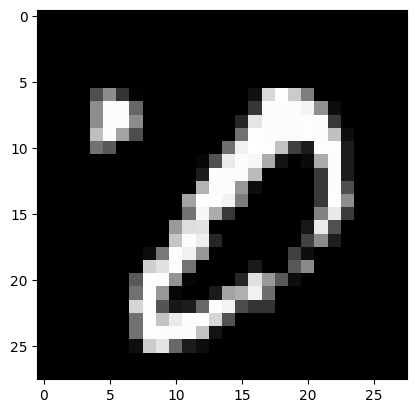

Predicted: 7, Correct: 2


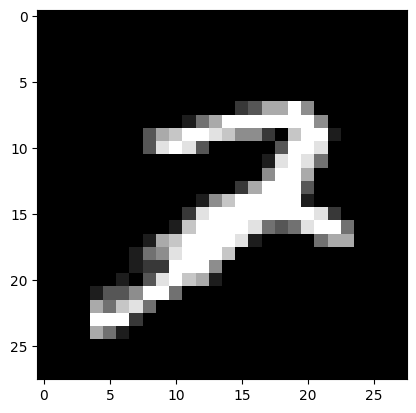

Predicted: 1, Correct: 6


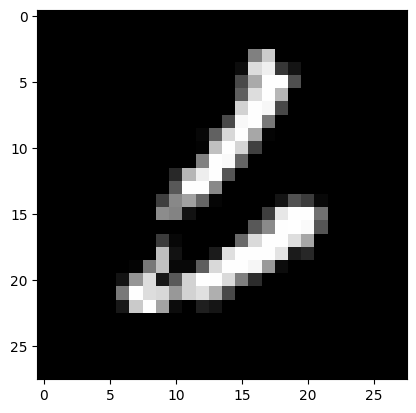

Predicted: 7, Correct: 9


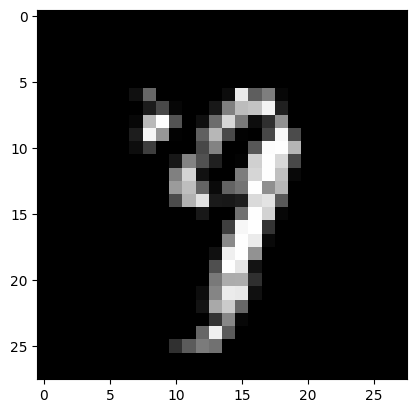

Predicted: 1, Correct: 2


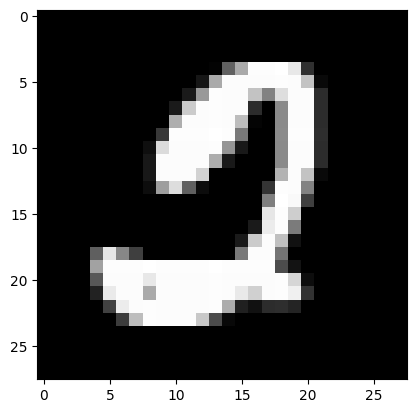

Predicted: 1, Correct: 2


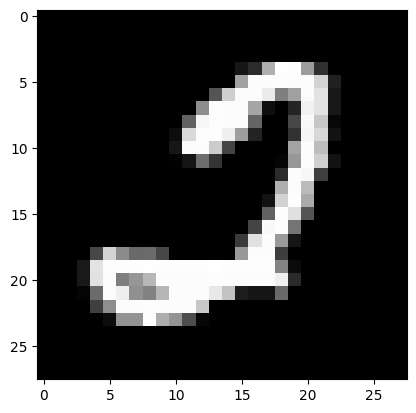

Predicted: 6, Correct: 5


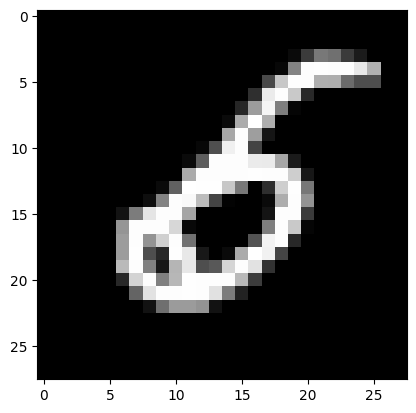

Predicted: 7, Correct: 2


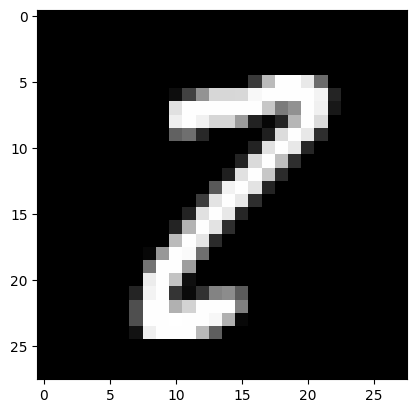

Val Loss: 0.1100, Val Acc: 98.40


In [51]:
# validation

# save wrong predictions and data to wrong [predicted, correct, data]

wrong = []

model.eval()
val_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for data, labels in val_loader: 
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        val_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # print wrong predictions and plot 
        for i in range(len(predicted)): 
            if predicted[i] != labels[i]: 
                wrong.append(data[i].cpu().numpy())
                print(f"Predicted: {predicted[i]}, Correct: {labels[i]}")
                plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
                plt.show()
                

val_loss /= len(val_loader)
val_acc = 100 * correct / total
print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")


In [26]:
# load test data
test_data = load_data("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_label("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")


In [27]:
# np to tensor
test_data = torch.tensor(test_data).float()
test_labels = torch.tensor(test_labels).long()

In [28]:
# unsqueeze to add channel dimension
test_data = test_data.unsqueeze(1)

In [29]:
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [52]:
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader: 
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_loader)
test_acc = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")
print(f"Wrong predictions: {len(wrong)}")


Test Loss: 0.0056, Test Acc: 99.92
Wrong predictions: 8


In [32]:
# save model
torch.save(model.state_dict(), "model.pth")

In [33]:
# load model from file 
model = Net().to(device)
model.load_state_dict(torch.load("model.pth"))


C:\Users\yinch\AppData\Local\Temp\ipykernel_94520\1869540630.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

In [35]:
# try model on train data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in train_loader: 
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

train_acc = 100 * correct / total
print(f"Train Acc: {train_acc:.2f}")


Train Acc: 99.92
